# Business Growth Overview

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Import Data Source

In [3]:
data_src = "Raw-Agg Perf Nationwide_Wk 2023021.csv"
cols = ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'TM_KEY_YR', 'CENTER', 'METRIC_GRP', 'COMP_CD', 'PRODUCT_GRP', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_AS_OF', 'AGG_TYPE', 'RR_IND', 'GRY_IND', 'UOM', 'PERIOD', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'PPN_TM']
df = pd.read_csv(data_src, low_memory=False)
df = df[cols]

curr_yr = max(df['TM_KEY_YR'])
last_yr = max(df['TM_KEY_YR'])-1
curr_mth = max(df['TM_KEY_MTH'])
curr_mth_desc = pd.to_datetime(curr_mth, format='%Y%m', errors='coerce').strftime('%B')
last_mth = int(f'{str(last_yr)}01') if str(curr_mth)[4:]=='01' else curr_mth-1
curr_wk = max(df['TM_KEY_WK'])
curr_day = max(df['TM_KEY_DAY'])
last_ppn_tm = max(df['PPN_TM'])

# df.head(3)

In [4]:
df.shape

(46592, 21)

## Week period

In [60]:
first_wk_day = df.groupby('TM_KEY_WK').agg({'TM_KEY_DAY': 'min'}).reset_index()
last_wk_day = df.groupby('TM_KEY_WK').agg({'TM_KEY_DAY': 'max'}).reset_index()
wk_day_period = pd.merge(first_wk_day, last_wk_day, on='TM_KEY_WK')
wk_day_period.tail(3)

,TM_KEY_WK,TM_KEY_DAY_x,TM_KEY_DAY_y
11,2023020,20230515,20230521
12,2023021,20230522,20230528
13,2023022,20230529,20230530


## Preview Data

In [ ]:
df_tmp = df[df['CENTER'] == 'Sales & Revenue']
df_tmp.head(3)
# df_tmp.to_excel("temp.xlsx")

In [ ]:
df_tmp['AGG_TYPE'].unique()
df_tmp.groupby('AGG_TYPE').size()
# df_tmp.shape

In [ ]:
df_agg_n = df_tmp[df_tmp['AGG_TYPE']=='N'].sort_values('TM_KEY_DAY')
df_agg_n.head(3)
# df_agg_n['METRIC_NAME'].unique()

## BG Revenue Data prep

In [5]:
# bg_cd_list = ['B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100', 'TNSC00142'] # include "TDG Revenue (Performance View)"
bg_rev_cd_list = ['B1R000100', 'B2R000100', 'TB3R000100', 'TB4R000100']
df_rev = df[df['METRIC_CD'].isin(bg_rev_cd_list)].reset_index()

def unit_mb(baht):
    n = baht
    unit_mb = n / 1000000
    return unit_mb

# # df_rev['ACTUAL_SNAP_TEST'] = df_rev.apply(lambda row : unit_mb(row['ACTUAL_SNAP']), axis=1)
df_rev.loc[:, 'ACTUAL_SNAP'] = unit_mb(df_rev['ACTUAL_SNAP'])
df_rev.loc[:, 'ACTUAL_AGG'] = unit_mb(df_rev['ACTUAL_AGG'])
df_rev.loc[:, 'TARGET_SNAP'] = unit_mb(df_rev['TARGET_SNAP'])
df_rev.loc[:, 'TARGET_AGG'] = unit_mb(df_rev['TARGET_AGG'])
df_rev['MTH_DESC'] = pd.to_datetime(df_rev['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')

df_rev.tail(3)

,index,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,TM_KEY_YR,CENTER,METRIC_GRP,COMP_CD,PRODUCT_GRP,METRIC_CD,...,RR_IND,GRY_IND,UOM,PERIOD,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,PPN_TM,MTH_DESC
361,42949,20230528,2023021,202305,2023,Sales & Revenue,Revenue,TRUE,TVS,TB4R000100,...,0,GYR,baht,M,15.905405,139.790967,16.599735,265.776482,2023-05-31 13:48:22,May
362,42950,20230529,2023022,202305,2023,Sales & Revenue,Revenue,TRUE,TVS,TB4R000100,...,0,GYR,baht,M,NaN,139.790967,NaN,265.776482,2023-05-31 13:48:22,May
363,42951,20230530,2023022,202305,2023,Sales & Revenue,Revenue,TRUE,TVS,TB4R000100,...,0,GYR,baht,M,NaN,139.790967,NaN,265.776482,2023-05-31 13:48:22,May


In [244]:
df_rev.dtypes
df_rev.shape

(364, 23)

## Pivot Revenue by Product

In [6]:
# df_rev_pivot = df_rev.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'MTH_DESC'], columns=['METRIC_NAME'], values=['ACTUAL_SNAP', 'TARGET_SNAP'])#.reset_index()
df_rev_pivot = df_rev.pivot(index=['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'MTH_DESC'], columns=['METRIC_NAME'], values='ACTUAL_SNAP').reset_index()
df_rev_pivot.tail()

METRIC_NAME,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,MTH_DESC,Postpaid Revenue,Prepaid Revenue,TOL Revenue,TVS Revenue
86,20230526,2023021,202305,May,99.748573,120.593038,NaN,NaN
87,20230527,2023021,202305,May,96.596820,116.778286,NaN,NaN
88,20230528,2023021,202305,May,465.526614,70.492004,156.700035,15.905405
89,20230529,2023022,202305,May,NaN,NaN,NaN,NaN
90,20230530,2023022,202305,May,NaN,NaN,NaN,NaN


## Visualization
##### https://matplotlib.org/stable/tutorials/introductory/pyplot.html

In [8]:
# BG Revenue Rawdata
df_rev_agg = df_rev.loc[:, ['TM_KEY_DAY', 'TM_KEY_WK', 'TM_KEY_MTH', 'METRIC_CD', 'METRIC_NAME', 'ACTUAL_SNAP', 'ACTUAL_AGG', 'TARGET_SNAP', 'TARGET_AGG', 'MTH_DESC']]
# df_rev_agg['MTH_DESC'] = pd.to_datetime(df_rev_agg['TM_KEY_MTH'], format='%Y%m', errors='coerce').dt.strftime('%B')
# df_rev_agg.to_excel('temp.xlsx')
df_rev_agg.tail(3)

,TM_KEY_DAY,TM_KEY_WK,TM_KEY_MTH,METRIC_CD,METRIC_NAME,ACTUAL_SNAP,ACTUAL_AGG,TARGET_SNAP,TARGET_AGG,MTH_DESC
361,20230528,2023021,202305,TB4R000100,TVS Revenue,15.905405,139.790967,16.599735,265.776482,May
362,20230529,2023022,202305,TB4R000100,TVS Revenue,NaN,139.790967,NaN,265.776482,May
363,20230530,2023022,202305,TB4R000100,TVS Revenue,NaN,139.790967,NaN,265.776482,May


In [198]:
df_rev_agg.shape

(364, 10)

## Monthly Performance

In [ ]:
# Rawdata by month
df_rev_mth = df_rev_agg.groupby(['TM_KEY_MTH', 'MTH_DESC']).sum()[['ACTUAL_SNAP', 'TARGET_SNAP']].reset_index()
df_rev_mth['%ACHIEVE'] = (df_rev_mth['ACTUAL_SNAP'] / df_rev_mth['TARGET_SNAP']) * 100
df_rev_mth['ACTUAL_DIFF'] = df_rev_mth['ACTUAL_SNAP'].diff()
df_rev_mth['LAST_MTH_ACTUAL'] = df_rev_mth['ACTUAL_SNAP'] - df_rev_mth['ACTUAL_DIFF']

# Aggregation
x = df_rev_mth['MTH_DESC']
x_axis = np.arange(len(x))
y_act = df_rev_mth['ACTUAL_SNAP'].round(2)
y_tgt = df_rev_mth['TARGET_SNAP'].round(2)
y_ach = df_rev_mth['%ACHIEVE'].round(2)
y_diff = df_rev_mth['ACTUAL_DIFF'].round(2)
y_last_act = df_rev_mth['LAST_MTH_ACTUAL'].round(2)

# df_rev_mth

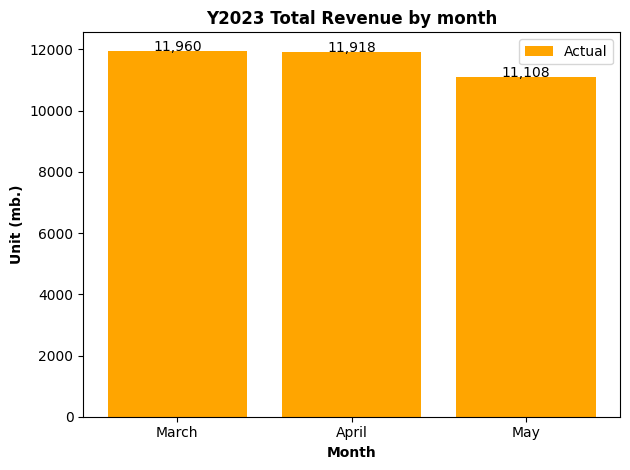

In [277]:
# plt.figure().set_figwidth(12)

plt.bar(x_axis, y_act, label='Actual', color='orange')
for i in x_axis:    
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i], y_act[i]), ha='center')    
plt.xticks(x_axis, x)
plt.xlabel('Month', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title(f'Y{curr_yr} Total Revenue by month', fontdict={'fontweight': 'bold'})
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# plt.figure().set_figwidth(12)

plt.plot(x_axis, y_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='y')
plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Actual', color='r')
for i in x_axis:
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i]+0.1, y_act[i]))
    # plt.annotate(str(format(y_tgt[i],',.0f')), xy=(x_axis[i]+0.1, y_tgt[i]))
plt.xticks(x_axis, x)
plt.xlabel('Month', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title(f'Y{curr_yr} Total Revenue : Monthly trend', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Monthly Perf by Product

In [318]:
# Rawdata
df_prod_rev_mth = df_rev_pivot.groupby(['TM_KEY_MTH', 'MTH_DESC']).sum()[['Prepaid Revenue', 'Postpaid Revenue', 'TOL Revenue', 'TVS Revenue']].reset_index()
# df_prod_rev_mth = df_rev_pivot.groupby(['TM_KEY_MTH', 'MTH_DESC']).sum()[['ACTUAL_SNAP', 'TARGET_SNAP']].reset_index()
# df_prod_rev_mth['ACTUAL_SNAP']['Prepaid Revenue']

# Aggregation
x = df_prod_rev_mth['MTH_DESC']
x_axis = np.arange(len(x))
y_pre = df_prod_rev_mth['Prepaid Revenue'].round(2)
y_post = df_prod_rev_mth['Postpaid Revenue'].round(2)
y_tol = df_prod_rev_mth['TOL Revenue'].round(2)
y_tvs = df_prod_rev_mth['TVS Revenue'].round(2)

# df_prod_rev_mth

In [ ]:
# plt.figure().set_figwidth(12)

plt.plot(x_axis, y_pre, marker='.', markeredgewidth=3, label='Prepaid', color='c')
plt.plot(x_axis, y_post, marker='.', markeredgewidth=3, label='Postpaid', color='r')
plt.plot(x_axis, y_tol, marker='.', markeredgewidth=3, label='TOL', color='b')
plt.plot(x_axis, y_tvs, marker='.', markeredgewidth=3, label='TVS', color='y')

plt.xticks(x_axis, x)
plt.xlabel('Month', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title(f'Y{curr_yr} Revenue by Product : Monthly trend', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Weekly Performance

In [320]:
# Rawdata by week
df_rev_wk = df_rev_agg.groupby('TM_KEY_WK').sum()[['ACTUAL_SNAP','TARGET_SNAP']].reset_index()
df_rev_wk['%ACHIEVE'] = (df_rev_wk['ACTUAL_SNAP'] / df_rev_wk['TARGET_SNAP']) * 100
df_rev_wk['ACTUAL_DIFF'] = df_rev_wk['ACTUAL_SNAP'].diff().fillna(0)
df_rev_wk['LAST_WK_ACTUAL'] = df_rev_wk['ACTUAL_SNAP'] - df_rev_wk['ACTUAL_DIFF']
# df_rev_wk['FF_NULL_TEST'] = df_rev_wk['ACTUAL_DIFF'].fillna(0)

# Aggregation
x = df_rev_wk['TM_KEY_WK'].apply(str).str[5:].astype(int)
x_axis = np.arange(len(x))
y_act = df_rev_wk['ACTUAL_SNAP'].round(2)
y_tgt = df_rev_wk['TARGET_SNAP'].round(2)
y_ach = df_rev_wk['%ACHIEVE'].round(2)
y_diff = df_rev_wk['ACTUAL_DIFF'].round(2)
y_last_act = df_rev_wk['LAST_WK_ACTUAL'].round(2)

# df_rev_wk.tail()

In [ ]:
plt.figure().set_figwidth(12)

plt.bar(x_axis, y_act, label='Actual', color='orange')
for i in x_axis:    
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i], y_act[i]), ha='center')
plt.xticks(x_axis, x)
plt.xlabel('Week', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title(f'Y{curr_yr} Total Revenue by week', fontdict={'fontweight': 'bold'})
plt.legend()
plt.tight_layout()
plt.show()

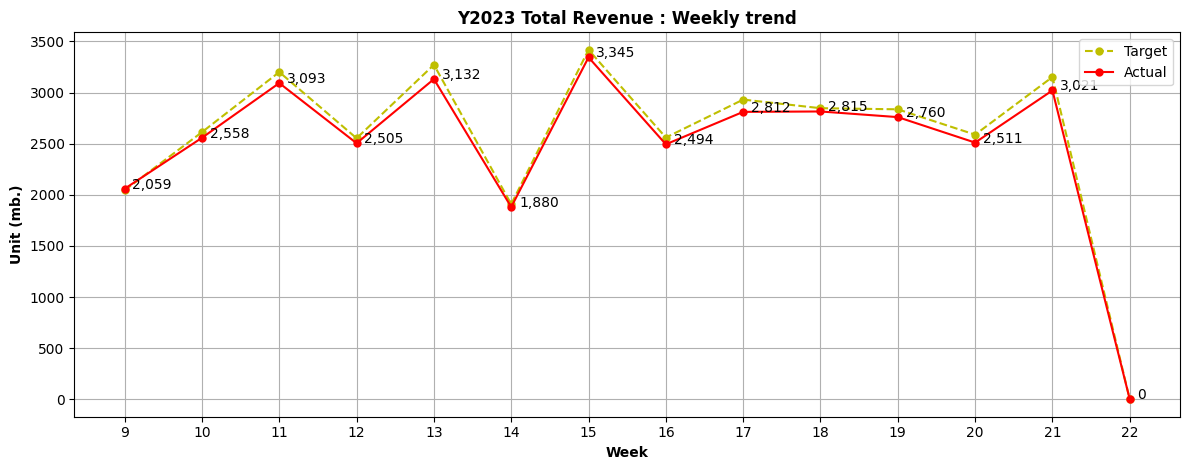

In [321]:
plt.figure().set_figwidth(12)

plt.plot(x_axis, y_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='y')
plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Actual', color='r')
for i in x_axis:
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i]+0.1, y_act[i]))
    # plt.annotate(str(format(y_tgt[i],',.0f')), xy=(x_axis[i]+0.1, y_tgt[i]))
plt.xticks(x_axis, x)
plt.xlabel('Week', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title(f'Y{curr_yr} Total Revenue : Weekly trend', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure().set_figwidth(12)

plt.subplot(211)
plt.plot(x_axis, y_ach, marker='.', markeredgewidth=3, label='% Achieve', color='y')
for i in x_axis:
    plt.annotate(str(format(y_ach[i]/100,',.2%')), xy=(x_axis[i]+0.1, y_ach[i]))
plt.xticks(x_axis, x)
plt.title(f'Y{curr_yr} Total Revenue : %Achieve & Different by week', fontdict={'fontweight': 'bold'})
plt.ylabel('% Achieve', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(x_axis, y_diff, marker='.', markeredgewidth=3, label='Diff by week', color='m')
for i in x_axis:
    plt.annotate(str(format(y_diff[i],',.0f')), xy=(x_axis[i]+0.1, y_diff[i]))
plt.xticks(x_axis, x)
plt.xlabel('Week', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Weekly Perf by Product

In [335]:
# Rawdata
df_prod_rev_wk = df_rev_pivot.groupby(['TM_KEY_WK', 'MTH_DESC']).sum()[['Prepaid Revenue', 'Postpaid Revenue', 'TOL Revenue', 'TVS Revenue']].reset_index()

# Aggregation
x = df_prod_rev_wk['TM_KEY_WK'].apply(str).str[5:].astype(int)
x_axis = np.arange(len(x))
y_pre = df_prod_rev_wk['Prepaid Revenue'].round(2)
y_post = df_prod_rev_wk['Postpaid Revenue'].round(2)
y_tol = df_prod_rev_wk['TOL Revenue'].round(2)
y_tvs = df_prod_rev_wk['TVS Revenue'].round(2)

# df_prod_rev_wk.tail(3)

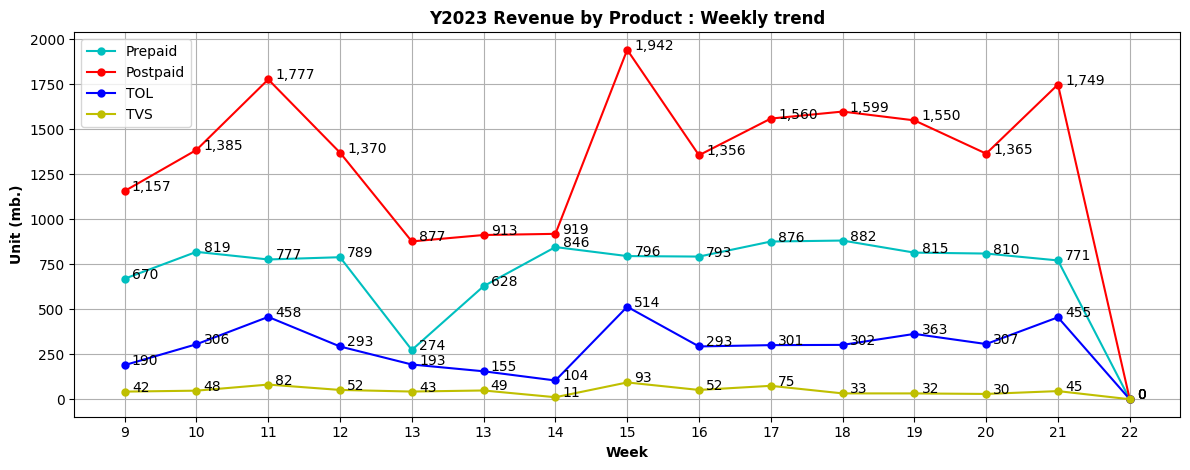

In [336]:
plt.figure().set_figwidth(12)

plt.plot(x_axis, y_pre, marker='.', markeredgewidth=3, label='Prepaid', color='c')
plt.plot(x_axis, y_post, marker='.', markeredgewidth=3, label='Postpaid', color='r')
plt.plot(x_axis, y_tol, marker='.', markeredgewidth=3, label='TOL', color='b')
plt.plot(x_axis, y_tvs, marker='.', markeredgewidth=3, label='TVS', color='y')
for i in x_axis:
    plt.annotate(str(format(y_pre[i],',.0f')), xy=(x_axis[i]+0.1, y_pre[i]))
    plt.annotate(str(format(y_post[i],',.0f')), xy=(x_axis[i]+0.1, y_post[i]))
    plt.annotate(str(format(y_tol[i],',.0f')), xy=(x_axis[i]+0.1, y_tol[i]))
    plt.annotate(str(format(y_tvs[i],',.0f')), xy=(x_axis[i]+0.1, y_tvs[i]))
plt.xticks(x_axis, x)
plt.xlabel('Week', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title(f'Y{curr_yr} Revenue by Product : Weekly trend', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Daily Performance : M2D

In [9]:
# Rawdata by day
df_rev_curr_mth = df_rev_agg[df_rev_agg['TM_KEY_MTH']==curr_mth].groupby('TM_KEY_DAY').sum()[['ACTUAL_SNAP','TARGET_SNAP']].reset_index()
df_rev_curr_mth['KEY_DAY'] = df_rev_curr_mth['TM_KEY_DAY'].apply(str).str[6:]

df_rev_last_mth = df_rev_agg[df_rev_agg['TM_KEY_MTH']==last_mth].groupby('TM_KEY_DAY').sum()[['ACTUAL_SNAP','TARGET_SNAP']].reset_index()
df_rev_last_mth['KEY_DAY'] = df_rev_last_mth['TM_KEY_DAY'].apply(str).str[6:]
df_rev_last_mth.rename(columns=({'TM_KEY_DAY': 'LAST_MTH_TM_KEY_DAY', 'ACTUAL_SNAP': 'LAST_MTH_ACTUAL', 'TARGET_SNAP': 'LAST_MTH_TARGET'}), inplace=True)

df_rev_day = pd.merge(df_rev_curr_mth, df_rev_last_mth, on='KEY_DAY')
df_rev_day['%ACHIEVE'] = (df_rev_day['ACTUAL_SNAP'] / df_rev_day['TARGET_SNAP']) * 100
df_rev_day['ACTUAL_DIFF'] = df_rev_day['ACTUAL_SNAP'].diff().fillna(0)
df_rev_day['LAST_DAY_ACTUAL'] = df_rev_day['ACTUAL_SNAP'] - df_rev_day['ACTUAL_DIFF']
# df_rev_day['FF_NULL_TEST'] = df_rev_day['ACTUAL_DIFF'].fillna(0)

# Aggregation
x = df_rev_day['KEY_DAY'].astype(int)
x_axis = np.arange(len(x))
y_act = df_rev_day['ACTUAL_SNAP'].round(2)
y_tgt = df_rev_day['TARGET_SNAP'].round(2)
y_ach = df_rev_day['%ACHIEVE'].round(2)
y_diff = df_rev_day['ACTUAL_DIFF'].round(2)
y_last_day_act = df_rev_day['LAST_DAY_ACTUAL'].round(2)
y_last_mth_act = df_rev_day['LAST_MTH_ACTUAL'].round(2)

# df_rev_day.tail(3)

In [ ]:
# plt.figure().set_figwidth(12)
plt.figure(figsize=(18,6))

plt.bar(x_axis, y_act, label='Actual', color='orange')
for i in x_axis:    
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i], y_act[i]), ha='center')
plt.xticks(x_axis, x)
plt.xlabel(curr_mth_desc, fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title(f'Y{curr_yr} Total Revenue by day', fontdict={'fontweight': 'bold'})
plt.legend()
plt.tight_layout()
plt.show()

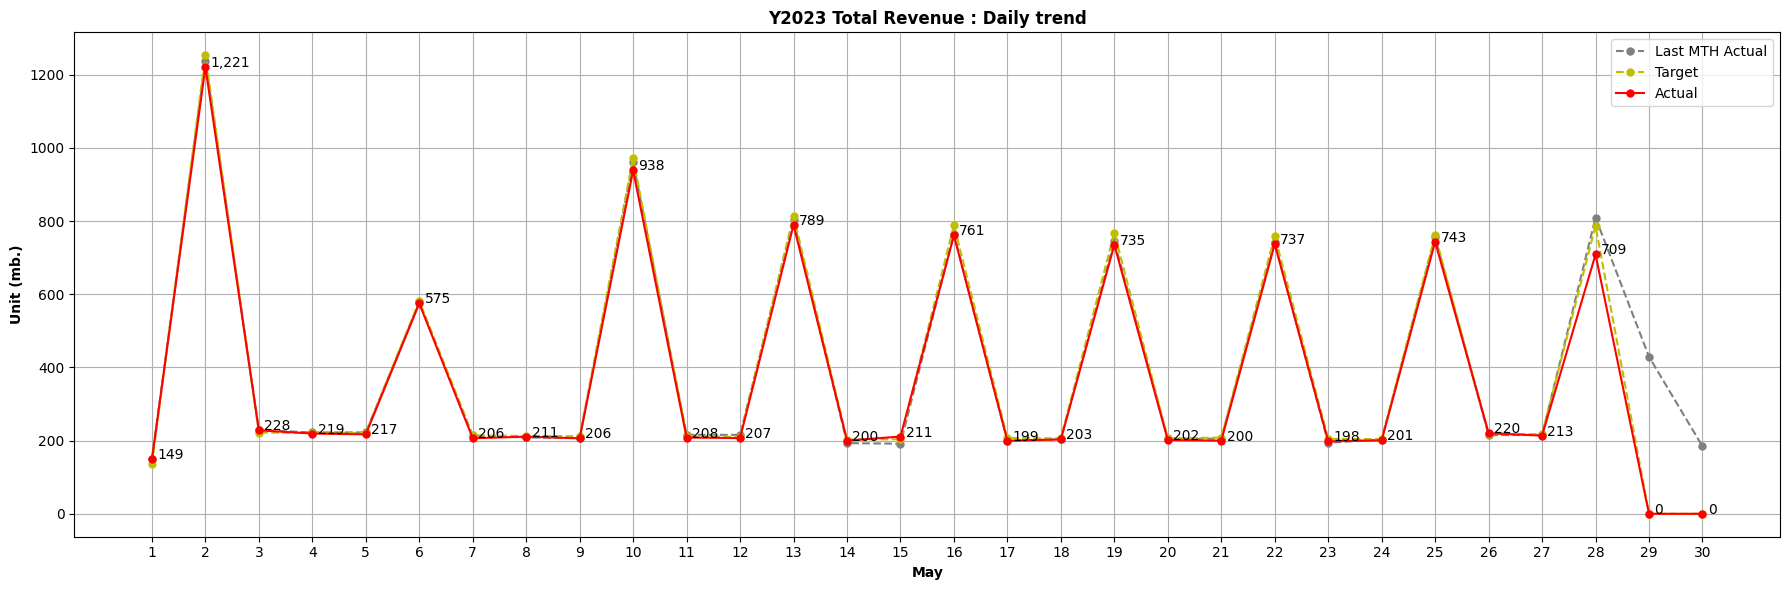

In [11]:
# plt.figure().set_figwidth(12)
plt.figure(figsize=(18,6))

plt.plot(x_axis, y_last_mth_act, marker='.', linestyle='dashed', markeredgewidth=3, label='Last MTH Actual', color='gray')
plt.plot(x_axis, y_tgt, marker='.', linestyle='dashed', markeredgewidth=3, label='Target', color='y')
plt.plot(x_axis, y_act, marker='.', markeredgewidth=3, label='Actual', color='r')
for i in x_axis:
    plt.annotate(str(format(y_act[i],',.0f')), xy=(x_axis[i]+0.1, y_act[i]))
    # plt.annotate(str(format(y_tgt[i],',.0f')), xy=(x_axis[i]+0.1, y_tgt[i]))
plt.xticks(x_axis, x)
plt.xlabel(curr_mth_desc, fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title(f'Y{curr_yr} Total Revenue : Daily trend', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# plt.figure().set_figwidth(12)
plt.figure(figsize=(18,6))

plt.subplot(211)
plt.plot(x_axis, y_ach, marker='.', markeredgewidth=3, label='% Achieve', color='y')
for i in x_axis:
    plt.annotate(str(format(y_ach[i]/100,',.2%')), xy=(x_axis[i]+0.1, y_ach[i]))
plt.xticks(x_axis, x)
plt.title(f'Y{curr_yr} Total Revenue : %Achieve & Different last day', fontdict={'fontweight': 'bold'})
plt.ylabel('% Achieve', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(x_axis, y_diff, marker='.', markeredgewidth=3, label='Diff last day', color='m')
for i in x_axis:
    plt.annotate(str(format(y_diff[i],',.0f')), xy=(x_axis[i]+0.1, y_diff[i]))
plt.xticks(x_axis, x)
plt.xlabel(curr_mth_desc, fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Daily M2D Perf by Product

In [13]:
# Rawdata
df_prod_rev_day = df_rev_pivot[df_rev_pivot['TM_KEY_MTH']==curr_mth].groupby('TM_KEY_DAY').sum()[['Prepaid Revenue', 'Postpaid Revenue', 'TOL Revenue', 'TVS Revenue']].reset_index()

# Aggregation
x = df_prod_rev_day['TM_KEY_DAY'].apply(str).str[6:].astype(int)
x_axis = np.arange(len(x))
y_pre = df_prod_rev_day['Prepaid Revenue'].round(2)
y_post = df_prod_rev_day['Postpaid Revenue'].round(2)
y_tol = df_prod_rev_day['TOL Revenue'].round(2)
y_tvs = df_prod_rev_day['TVS Revenue'].round(2)

df_prod_rev_day.tail(3)

METRIC_NAME,TM_KEY_DAY,Prepaid Revenue,Postpaid Revenue,TOL Revenue,TVS Revenue
27,20230528,70.492004,465.526614,156.700035,15.905405
28,20230529,0.000000,0.000000,0.000000,0.000000
29,20230530,0.000000,0.000000,0.000000,0.000000


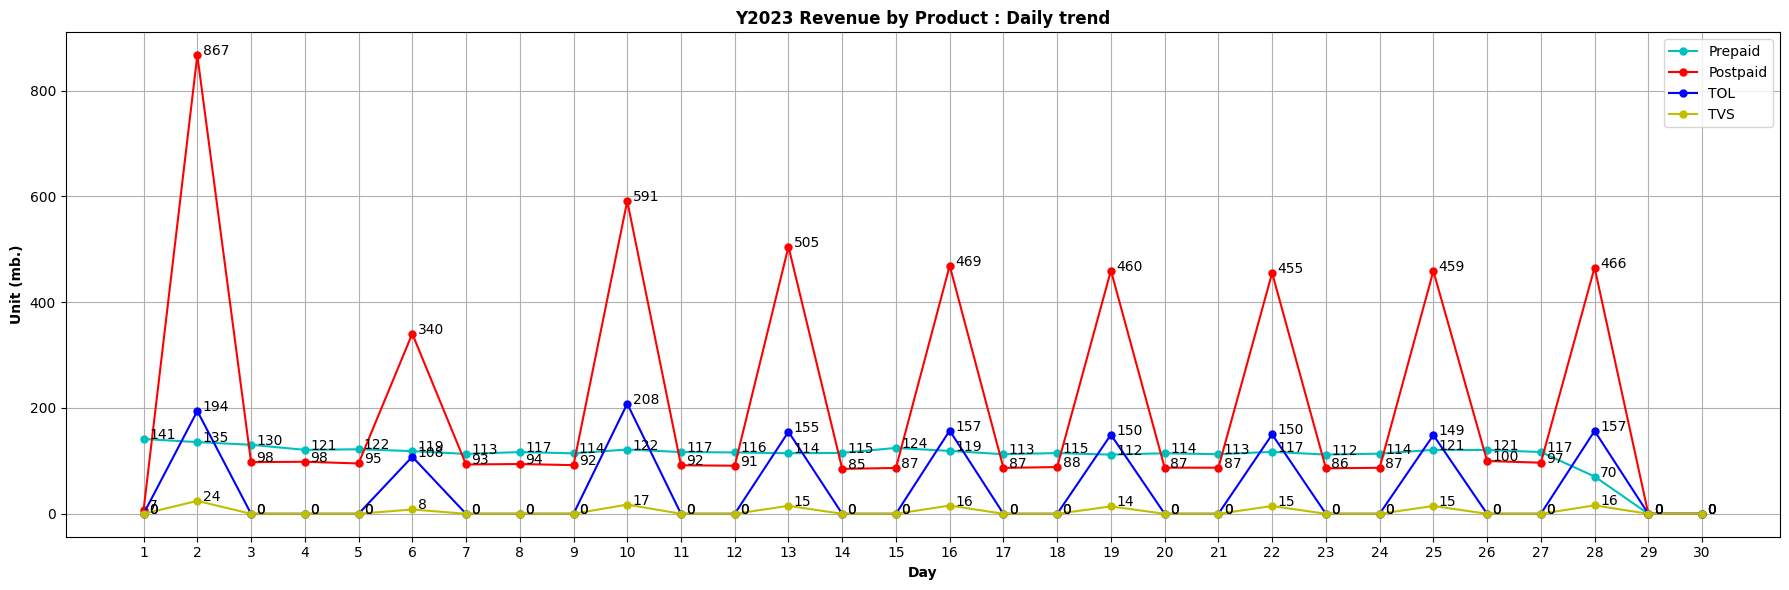

In [18]:
# plt.figure().set_figwidth(12)
plt.figure(figsize=(18,6))

plt.plot(x_axis, y_pre, marker='.', markeredgewidth=3, label='Prepaid', color='c')
plt.plot(x_axis, y_post, marker='.', markeredgewidth=3, label='Postpaid', color='r')
plt.plot(x_axis, y_tol, marker='.', markeredgewidth=3, label='TOL', color='b')
plt.plot(x_axis, y_tvs, marker='.', markeredgewidth=3, label='TVS', color='y')
for i in x_axis:
    plt.annotate(str(format(y_pre[i],',.0f')), xy=(x_axis[i]+0.1, y_pre[i]))
    plt.annotate(str(format(y_post[i],',.0f')), xy=(x_axis[i]+0.1, y_post[i]))
    plt.annotate(str(format(y_tol[i],',.0f')), xy=(x_axis[i]+0.1, y_tol[i]))
    plt.annotate(str(format(y_tvs[i],',.0f')), xy=(x_axis[i]+0.1, y_tvs[i]))
plt.xticks(x_axis, x)
plt.xlabel('Day', fontdict={'fontweight': 'bold'})
plt.ylabel('Unit (mb.)', fontdict={'fontweight': 'bold'})
plt.title(f'Y{curr_yr} Revenue by Product : Daily trend', fontdict={'fontweight': 'bold'})
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()